## Introduction

Uses the 2007 TREC Public Spam Corpus copyright 2005 Gordon V. Cormack and Thomas R. Lynam.
    
The corpus trec07p contains 75,419 messages (25220 ham and 50199 spam).
This notebook processes the original (raw) dataset available from https://plg.uwaterloo.ca/~gvcormac/treccorpus07/.


## Import Libraries

In [90]:
import numpy as np
import pandas as pd
import re
import string
import nltk  
import random
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from email.parser import Parser
from langdetect import detect
from collections import Counter

## 1. Process Raw Data

Note: Unzip trec07p.tgz in the data folder.

In [36]:
data = pd.read_csv("../data/trec07p/full/index",sep=' ',header=None)
data.head()

,0,1
0,spam,../data/inmail.1
1,ham,../data/inmail.2
2,spam,../data/inmail.3
3,spam,../data/inmail.4
4,spam,../data/inmail.5


In [37]:
data.columns=['class','filepath']
data['contents'] = None
data.head()

,class,filepath,contents
0,spam,../data/inmail.1,None
1,ham,../data/inmail.2,None
2,spam,../data/inmail.3,None
3,spam,../data/inmail.4,None
4,spam,../data/inmail.5,None


In [38]:
parser = Parser()
    
for i,row in tqdm(data.iterrows(),total=data.shape[0]):
    body = ''    
    filepath=row['filepath'].replace('../data', '../data/trec07p/data')
    with open(filepath, 'r', encoding='ISO-8859-1') as ifile:
        email = parser.parse(ifile)
        
    if email.is_multipart():
        for part in email.walk():
            content_type = part.get_content_type()
            content_dispo = str(part.get('Content-Disposition'))

            # Skip any text/plain (txt) attachments
            if content_type == 'text/plain' and 'attachment' not in content_dispo:
                body = part.get_payload(decode=False)
                break ## Only keep the first email
    else:
        body = email.get_payload(decode=False)
      
    # if i > 20: break
    
    # Remove html tags and newlines
    body = re.sub('<[^<]+?>', '', body)
    body = body.replace('\n','')
    # Because this is Canadian, there is some French. Remove it.
    try:
        langs = detect(body)
        if langs !='en':
            raise Exception('Body content is not English.')
        data.at[i,'contents']= body
    except:
        data.at[i,'contents']= np.nan
        
print(data.head(10))
print(data.info())

100%|███████████████████████████████████████████████████████████████████████████████████| 75419/75419 [28:16<00:00, 44.45it/s]

  class           filepath                                           contents
0  spam   ../data/inmail.1                                                NaN
1   ham   ../data/inmail.2  Hi, i've just updated from the gulus and I che...
2  spam   ../data/inmail.3  Mega  authenticV I A G R A   $ DISCOUNT priceC...
3  spam   ../data/inmail.4  Hey Billy, it was really fun going out the oth...
4  spam   ../data/inmail.5  system" of the home.  It will have the capabil...
5  spam   ../data/inmail.6  the program and the creative abilities of the ...
6  spam   ../data/inmail.7  Glad to see you!Look at the assortment of our ...
7  spam   ../data/inmail.8                                                NaN
8  spam   ../data/inmail.9    HoodiaLife - Start Losing Weight Now!HoodiaL...
9   ham  ../data/inmail.10  Hi...I have to use R to find out the 90% confi...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75419 entries, 0 to 75418
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dty

In [39]:
# Cache this data
data.to_csv('../data/trec2007_spam_data_cached.csv', index=False)

## 2. Data Cleaning

In [49]:
data = pd.read_csv("../data/trec2007_spam_data_cached.csv")
data.head(3)

,class,filepath,contents
0,spam,../data/inmail.1,NaN
1,ham,../data/inmail.2,"Hi, i've just updated from the gulus and I che..."
2,spam,../data/inmail.3,Mega authenticV I A G R A $ DISCOUNT priceC...


### 2.1 Remove Unecessary Columns

In [50]:
data.drop(['filepath'], axis = 1, inplace = True)
data.head(3)

,class,contents
0,spam,NaN
1,ham,"Hi, i've just updated from the gulus and I che..."
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...


### 2.2 Drop Missing Values


In [51]:
print('Number of samples before {}'.format(len(data)))
data.dropna(inplace = True)
print('Number of samples After {}'.format(len(data)))

Number of samples before 75419
Number of samples After 60519


## 3. Create Additional Features

### 3.1 Create a binary label encoding on Spam/Ham

In [53]:
data['target'] = data['class'].map({'ham':0, 'spam':1})
data.head(3)

,class,contents,target
1,ham,"Hi, i've just updated from the gulus and I che...",0
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...,1
3,spam,"Hey Billy, it was really fun going out the oth...",1


### 3.2 Create columns to tally punctuation

In [56]:
for punctu in string.punctuation:
    data[punctu] = data['contents'].map(lambda v : v.count(punctu))

data.head(3)

,class,contents,target,!,"""",#,$,%,&,',...,[,\,],^,_,`,{,|,},~
1,ham,"Hi, i've just updated from the gulus and I che...",0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,spam,"Hey Billy, it was really fun going out the oth...",1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


### 3.3 Create a column to tally message body length (via counting # of spaces)

In [58]:
data['msg_body_len'] = data.contents.apply(lambda x: len(x) - x.count(" "))
data.head(3)

,class,contents,target,!,"""",#,$,%,&,',...,\,],^,_,`,{,|,},~,msg_body_len
1,ham,"Hi, i've just updated from the gulus and I che...",0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,626
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,102
3,spam,"Hey Billy, it was really fun going out the oth...",1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,511


### 3.4 Create a column to accout for the % of punctuation to message body length

In [59]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3) * 100

data['punct%'] = data.contents.apply(lambda x: count_punct(x))
data.head(3)

,class,contents,target,!,"""",#,$,%,&,',...,],^,_,`,{,|,},~,msg_body_len,punct%
1,ham,"Hi, i've just updated from the gulus and I che...",0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,0,0,626,8.3
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,102,8.8
3,spam,"Hey Billy, it was really fun going out the oth...",1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,511,4.9


## 4. Cleaning Message

- #### Turn words into lowercase letters
- #### Remove numerical digits
- #### Remove punctuation
- #### Tokenization - split a sentence into a list of words 
- #### Remove stopwords - to remove tokens not contributing to the overall meaning of a sentence
- #### Lemmatization - condense variations of the same word to its root form

In [60]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/mzaghi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/mzaghi/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [61]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

### 4.1 Clean Message into Tokenized Words

In [64]:
def clean_msg_tokenize(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    tokens = re.findall('\S+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text

data['clean_msg_tokens'] = data['contents'].apply(lambda x: clean_msg_tokenize(x))

### 4.2 Clean Message for N-Grams Vectorization

In [65]:
def clean_msg(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    #text = re.sub('[0-9]+', '', text)
    tokens = re.findall('\S+', text)
    text = " ".join([wn.lemmatize(word) for word in tokens if word not in stopwords])
    return text

data['cleaned_msg'] = data['contents'].apply(lambda x: clean_msg(x))

In [66]:
data.head()

,class,contents,target,!,"""",#,$,%,&,',...,_,`,{,|,},~,msg_body_len,punct%,clean_msg_tokens,cleaned_msg
1,ham,"Hi, i've just updated from the gulus and I che...",0,0,4,0,0,0,0,1,...,0,0,0,0,0,0,626,8.3,"[hi, ive, updated, gulu, check, mirrorsit, see...",hi ive updated gulu check mirrorsit seems litt...
2,spam,Mega authenticV I A G R A $ DISCOUNT priceC...,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,102,8.8,"[mega, authenticv, g, r, discount, pricec, l, ...",mega authenticv g r discount pricec l discount...
3,spam,"Hey Billy, it was really fun going out the oth...",1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,511,4.9,"[hey, billy, really, fun, going, night, talkin...",hey billy really fun going night talking said ...
4,spam,"system"" of the home. It will have the capabil...",1,0,3,0,0,0,1,6,...,0,0,0,0,0,0,2101,4.3,"[system, home, capability, linked, far, know, ...",system home capability linked far know within ...
5,spam,the program and the creative abilities of the ...,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2055,3.5,"[program, creative, ability, artist, monitorin...",program creative ability artist monitoring eco...


In [67]:
trec = data.copy()

### 4.3 Additional Query & Cleaning of Stopwords

In [85]:
# Collect words from each row/list labeled ham
ham_words = list(trec.loc[trec['class'] == 'ham', 'clean_msg_tokens'])
# Flatten list of lists
ham_words = [word for sublist in ham_words for word in sublist]
# Create dictionary to store word frequency
ham_words = Counter(ham_words)
pd.DataFrame(ham_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,email,17075
1,code,15165
2,mailing,14768
3,new,13319
4,r,13304
5,wrote,12859
6,read,12537
7,would,12466
8,use,12276
9,file,12212


In [86]:
# Collect words from each row/list labeled ham
spam_words = list(trec.loc[trec['class'] == 'spam', 'clean_msg_tokens'])

# Flatten list of lists
spam_words = [word for sublist in spam_words for word in sublist]

# Create dictionary to store word frequency
spam_words = Counter(spam_words)
pd.DataFrame(spam_words.most_common(50), columns = ['word', 'frequency'])

,word,frequency
0,price,18377
1,pill,15206
2,one,13371
3,per,12143
4,product,12033
5,u,11045
6,online,10003
7,said,9760
8,x,9525
9,like,9325


In [87]:
# https://www.ranks.nl/stopwords
# unsure stop words but used (# e = ?, j = ?, de = ?, p = ?, 'b', 'de')

# Define extra stopwords
extra_stopwords = ['c', 'r', 'u', 'let', 'get', 'would', 'please', 'may', 'also', 'like', 'thanks', 'within', 'go', 'inc', 'make', 'could', 'want', 'need', 'new', 'know', 'best', 'e', 'j', 'p', 'b', 'de', 'see', 'take', 'made']

# Remove extra stopwords  
trec['clean_msg_tokens'] = trec['clean_msg_tokens'].apply(lambda x: [word for word in x if word not in extra_stopwords])

## 5. Exploratory Data Analysis

In [88]:
trec_eda = trec.copy()

### 5.1 Verify total number of spams vs hams

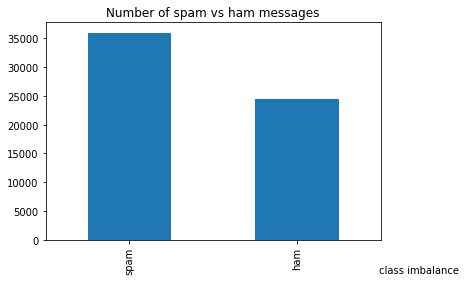

In [92]:
trec_eda['class'].value_counts().plot(kind = 'bar')
plt.figtext(0.99, 0.01, 'class imbalance', horizontalalignment = 'center')
plt.title("Number of spam vs ham messages");

### 5.2 Tallying Word Frequency Per Message

In [93]:
def clean_msg_rm_lst(msg_tokens):
    text = ' '.join(msg_tokens)
    return text

trec_eda['clean_msg_no_lst'] = trec_eda['clean_msg_tokens'].apply(lambda x: clean_msg_rm_lst(x))
trec_eda.head(1)

,class,contents,target,!,"""",#,$,%,&,',...,`,{,|,},~,msg_body_len,punct%,clean_msg_tokens,cleaned_msg,clean_msg_no_lst
1,ham,"Hi, i've just updated from the gulus and I che...",0,0,4,0,0,0,0,1,...,0,0,0,0,0,626,8.3,"[hi, ive, updated, gulu, check, mirrorsit, see...",hi ive updated gulu check mirrorsit seems litt...,hi ive updated gulu check mirrorsit seems litt...


In [94]:
trec_eda['word_count'] = trec_eda['clean_msg_no_lst'].apply(lambda v : len(v.split(" ")))
print('Max number of words in a message: ', trec_eda['word_count'].max())
print('Min number of words in a message: ', trec_eda['word_count'].min())

Max number of words in a message:  48739
Min number of words in a message:  1


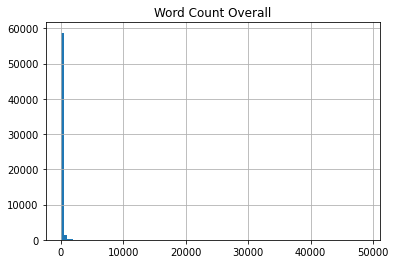

In [95]:
trec_eda['word_count'].hist(bins = 100)
plt.title('Word Count Overall');

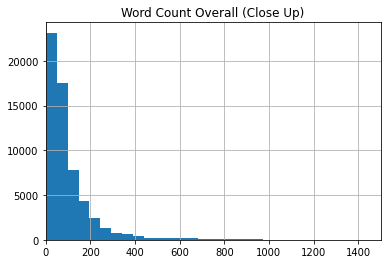

In [96]:
trec_eda['word_count'].hist(bins = 1000)
plt.title('Word Count Overall (Close Up)')
plt.xlim(-0.02, 1500);

### 5.3 Word Frequency Comparison (Spam vs Ham)

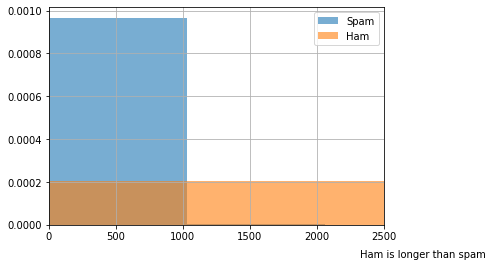

In [100]:
trec_eda[trec_eda['class'] == 'spam']['word_count'].hist(alpha = 0.6, density = True, label = 'Spam')
trec_eda[trec_eda['class'] == 'ham']['word_count'].hist(alpha = 0.6, density = True, label = 'Ham')
plt.legend()
plt.xlim(-0.02, 2500)
plt.figtext(0.99, 0.01, 'Ham is longer than spam', horizontalalignment = 'center');

### 5.4 Punctuation Frequency Comparison (Spam vs Ham)

In [ ]:
for punctu in string.punctuation:
    trec_eda[trec_eda['class'] == 'spam'][punctu].hist(alpha = 0.7, density = True, label = 'Spam')
    trec_eda[trec_eda['class'] == 'ham'][punctu].hist(alpha = 0.7, density = True, label = 'Ham')
    plt.legend()
    plt.title("Distribution of '" + punctu + "'")
    plt.show();